In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import networkx as nx
import time
from fun.fun import *

c:\Users\stirl\miniconda3\envs\network_env\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# START
edges_fn = "../data/edges.parquet"
communities_fn = "../data/communities.csv"
dataset_fn = "../dataset/TweetsCOV19.tsv"

In [3]:
# -> IN : Read edge list to dask df
print("reading edges ... ", end='')
start = time.time()
df = dd.read_parquet("../data/edges.parquet")
end = time.time()
print("read {:_} lines (took {:.1f}s)".format(len(df), (end-start)))

reading edges ... read 684_732_453 lines (took 0.2s)


In [4]:
# -> IN : Load tweets dataframe
tw = get_filtered_tweets_dataframe(dataset_fn)
print("Loaded {:_} tweets".format(len(tw)))

Importing dataset from tsv file ...read 8_077_794 lines (took 123.5s)
Converting timestamp column
Filtering desired columns and between desired dates ... 8_077_794 rows in dataframe
Parsing hashtags and positive/negative sentiments
filtering for tweets that contain hashtags ... 8_077_794 rows in dataframe
Loaded 462_901 tweets


In [5]:
# -> IN : Read list of nodes
#nodes = pd.read_csv('../data/node_ids.csv', index_col='twitter id')
nodes = pd.read_csv('../data/node_ids.csv', index_col='index')
print("Number of nodes: {:_}".format(len(nodes)))

Number of nodes: 410_885


In [6]:
# -> IN : Read node communities
#com = pd.read_csv(communities_fn, index_col='node')
com = pd.read_csv(communities_fn)

In [7]:
# Display top 10 communities
amount_of_communities = len(com['community'].unique())
print("amount of communities: {:,}".format(amount_of_communities))
comord = pd.DataFrame()
comord['component'] = range(1, amount_of_communities+1)
comord['amount of nodes'] = comord['component'].apply( lambda n: len(com[com['community'] == n]) )
comord.set_index('component', inplace=True)
comord.head(10)

amount of communities: 7,746


,amount of nodes
component,
1,385468
2,95
3,80
4,78
5,71
6,68
7,67
8,59
9,57


In [184]:
# Get average amount of nodes in communities
print("Average amount of nodes: {:.1f}".format(np.mean(comord['amount of nodes'])))

without_first_row = comord[comord['amount of nodes'] < 1000]
print("exclusing largest community: {:.1f}".format(np.mean(without_first_row['amount of nodes'])))

Average amount of nodes: 53.0
exclusing largest community: 3.3


Number of nodes: 52
Average shortest path length:  1.0


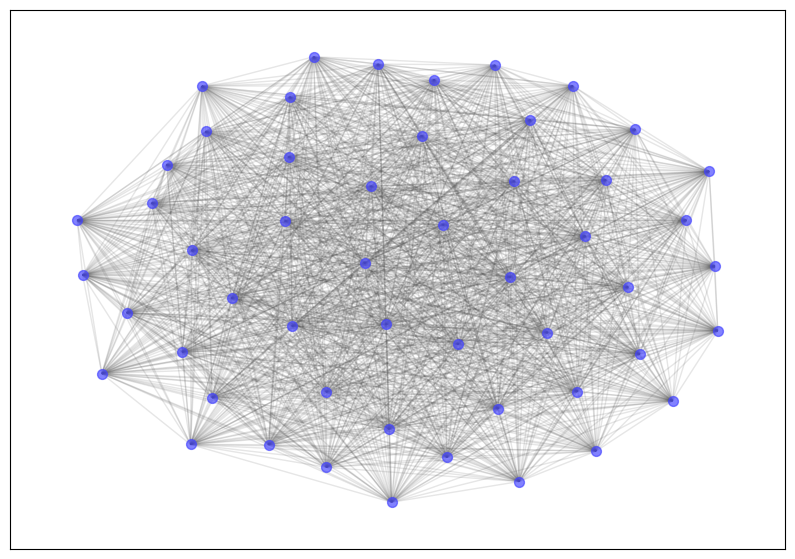

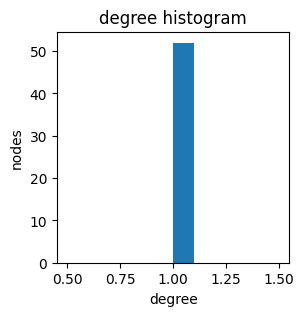

In [17]:
# Draw nth largest community (starts from 1. Also dont do 1)
n = 10
group = com[com['community'] == n]['node']
print("Number of nodes:", len(group))

edges = df[ (df['source'].isin(group)) & (df['target'].isin(group)) ].compute()
edges.head()

g = nx.Graph()
g.add_edges_from(edges.values.tolist())
layout = nx.spring_layout(g)

aspl = nx.average_shortest_path_length(g)
print("Average shortest path length: ", aspl)

node_colors = "#44fa"
edge_colors = "#4442"

plt.figure(figsize=(10,7))
nx.draw_networkx(g, pos=layout, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=50)
plt.show()

# degree centrality of connected component
plt.figure(figsize=(3,3))
plt.hist(list(nx.degree_centrality(g).values()))
plt.title("degree histogram")
plt.xlabel('degree')
plt.ylabel('nodes')
plt.show()



In [11]:
# Get hashtags appearing in group
hashtags = set()
for i in range(len(group)):
    node_i = group.iloc[i]
    node_id = nodes.loc[node_i]['twitter id']
    #print(node_id)
    for ht in tw.loc[str(node_id)]['Hashtags']:
        hashtags.add(ht)
for ht in hashtags:
    print(f"#{ht} ", end='')
print()
print(len(hashtags))

#NedimKaraçay.and #CemreYilmaz #Ozandolunay #cemned #CenkKaracay #AşkYokVicdanYok #CemreKaraçay #BerSer #cencem #CenkKaraçay #CenCem #BerkerGüven #zalimistanbul #NedimKaraçay #ozser #CemCen #SerBer #MineTugay #Cemned #ÖzürDilerim #OzanDolunay #Zalimİstanbul #CemNed #SeraKutlubey 
24


In [ ]:
# Average shortest paths of connected components
tw_sel = pd.DataFrame()

tw_sel['ids'] = np.array( tw[ (ts_lower <= tw['Timestamp']) & (tw['Timestamp'] < ts_upper) ].index ) # get nodes from timestamp range
print("{:>10_}".format(len(tw_sel)), end='')

tw_sel['ids'] = tw_sel['ids'].astype('int64')
tw_sel = tw_sel[tw_sel['ids'].isin(nodes.index)] # filter nodes that are indexed
tw_sel['index'] = tw_sel['ids'].apply( lambda id: nodes.loc[id]['index'] )
tw_sel['index'] = tw_sel['index'].astype('int32')

node_index = { node: index for index, node in enumerate( sorted(tw_sel['index'].tolist()) ) }

edges = df[ (df['source'].isin(tw_sel['index'])) & (df['target'].isin(tw_sel['index'])) ].compute()
edges['source_i'] = edges['source'].apply( lambda x: node_index[x] )
edges['target_i'] = edges['target'].apply( lambda x: node_index[x] )

g = ig.Graph()
g.add_vertices(len(node_index))
g.add_edges( edges[['source_i', 'target_i']].values.tolist() )